In [9]:
from phantominator import shepp_logan
from matplotlib import pyplot as plt

import torch

from loguru import logger
import pathlib
from natsort import natsorted, ns

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from quantization import *
from weight_compressors import *
from hyperparameter_sweeps import *
from benchmarkers import *

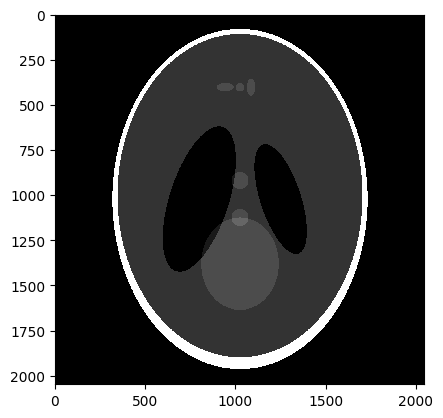

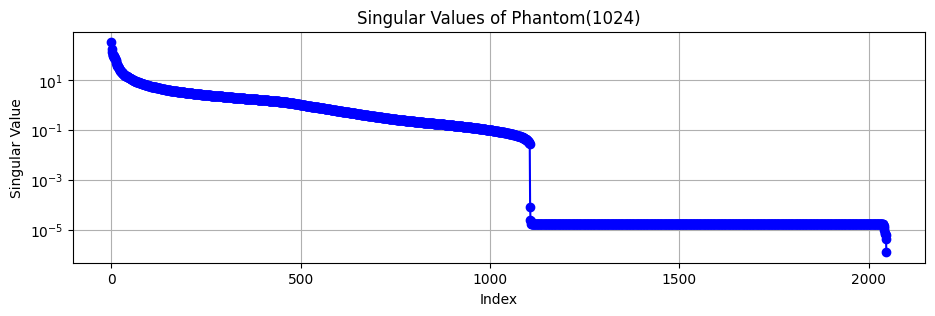

In [7]:
# Generate a phantominator matrix
X = torch.Tensor(shepp_logan(2048))
plt.imshow(X, cmap="gray", interpolation="nearest")
plt.show()

_, S, _ = torch.linalg.svd(X.float(), full_matrices=False)

# Plot the singular values
plt.figure(figsize=(11, 3))
plt.plot(S, marker='o', linestyle='-', color='b')
plt.title('Singular Values of Phantom(1024)')
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.yscale('log')
plt.grid(True)
plt.show()

In [8]:
def test_alternating_mixed_lplr(
    lplr_params=[{
        "alpha": 0.5, # Fraction of retained columns to be in full precision
        "beta": 0.4, # Fraction of columns to be retained
        "B1": 8,
        "B2": 8,
        "quantization_fn": quantize
    }],
    iters=10
):

    plot_colors = ["b", "r", "g", "c", "m", "k"]
    plot_markers = ["o", "X", "*"]
    # Set random seed for reproducibility
    torch.manual_seed(42)

    # Generate a phantominator matrix
    X = torch.Tensor(shepp_logan(2048))
    print(f"Phantom shape: {X.shape[1]}")

    plt.figure(figsize=(11, 3))

    for i, param_set in enumerate(lplr_params):
        kwargs = param_set.copy()
        kwargs["k"] = int(kwargs["beta"] * X.shape[1])
        kwargs["r1"] = int(kwargs["alpha"] * kwargs["k"])
        kwargs["r2"] = kwargs["r1"]
        kwargs["normalize_and_shift"] = True
        kwargs["log_errors"] = True
        kwargs["iters"] = iters
        del kwargs["alpha"]
        del kwargs["beta"]

        # Call alternating_mixed_lplr and retrieve errors
        kwargs["X"] = torch.Tensor(X)
        _, _, _, errors = alternating_mixed_lplr(**kwargs)

        fro_norm_X = torch.norm(X, p="fro").item()
        relative_errors = [error / fro_norm_X for error in errors]

        # Plot errors over iterations
        
        plt.plot(
            range(1, iters + 1),
            relative_errors,
            marker=plot_markers[(i // len(plot_colors)) % len(plot_markers)],
            linestyle="-",
            markersize=4,
            color=plot_colors[i % len(plot_colors)],
            label=f"Param Set {i+1}*")

    print("-"*80, "\n* Legend Key")
    for i, kwargs in enumerate(lplr_params):
        print(F"Param Set {i+1}: ", kwargs)

    plt.title("Frobenius Norm Errors over Iterations")
    plt.xlabel("Iteration")
    plt.ylabel("Error")
    plt.yscale("log")
    plt.grid(True)
    plt.legend()
    plt.show()

In [98]:
test_alternating_mixed_lplr([
    {
        "alpha": 0.5, # Fraction of retained columns to be in full precision
        "beta": 0.4, # Fraction of columns to be retained
        "B1": 8,
        "B2": 8,
        "quantization_fn": quantize
    },
    {
        "alpha": 0.5, # Fraction of retained columns to be in full precision
        "beta": 0.4, # Fraction of columns to be retained
        "B1": 8,
        "B2": 8,
        "quantization_fn": quantize_nf
    }
])

Phantom shape: 2048


KeyboardInterrupt: 

<Figure size 1100x300 with 0 Axes>

In [55]:
def test_loftq(
    lplr_params=[{
        "beta": 0.2, # Fraction of columns to be retained
        "B": 4,
        "quantization_fn": quantize
    }],
    iters=50
):

    plot_colors = ["b", "r", "g", "c", "m", "k"]
    plot_markers = ["o", "X", "*"]
    # Set random seed for reproducibility
    torch.manual_seed(42)

    # Generate a phantominator matrix
    X = torch.Tensor(shepp_logan(2048))
    print(f"Phantom shape: {X.shape[1]}")

    plt.figure(figsize=(11, 3))

    for i, param_set in enumerate(lplr_params):
        kwargs = param_set.copy()
        kwargs["r"] = int(kwargs["beta"] * X.shape[1])
        kwargs["normalize_and_shift"] = True
        kwargs["log_errors"] = True
        kwargs["iters"] = iters
        del kwargs["beta"]

        # Call alternating_mixed_lplr and retrieve errors
        kwargs["X"] = torch.Tensor(X)
        _, _, _, _, errors = loftq(**kwargs)

        fro_norm_X = torch.norm(X, p="fro").item()
        relative_errors = [error / fro_norm_X for error in errors]

        # Plot errors over iterations
        
        plt.plot(
            range(1, iters + 1),
            relative_errors,
            marker=plot_markers[(i // len(plot_colors)) % len(plot_markers)],
            linestyle="-",
            markersize=4,
            color=plot_colors[i % len(plot_colors)],
            label=f"Param Set {i+1}*")

    print("-"*80, "\n* Legend Key")
    for i, kwargs in enumerate(lplr_params):
        print(F"Param Set {i+1}: ", kwargs)

    plt.title("Frobenius Norm Errors over Iterations")
    plt.xlabel("Iteration")
    plt.ylabel("Error")
    plt.yscale("log")
    plt.grid(True)
    plt.legend()
    plt.show()

Phantom shape: 2048


100%|██████████| 50/50 [00:31<00:00,  1.60it/s]


-------------------------------------------------------------------------------- 
* Legend Key
Param Set 1:  {'beta': 0.2, 'B': 4, 'quantization_fn': <function quantize at 0x7f15f1f1cd30>}


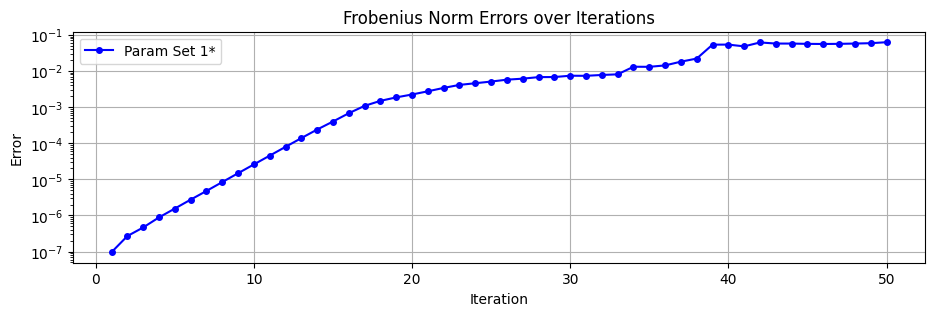

In [56]:
test_loftq()

In [86]:
X = torch.Tensor(shepp_logan(2048))
average_bit_level = 3
budget = X.shape[0] * X.shape[1] * average_bit_level

L_R_tuple, alpha, beta, B,  error = lplr_sweep_alpha_and_B(X, budget, debug=True)

--------------------------------------------------


2024-01-09 12:43:38.189 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:42 - B1=2, B2=2, alpha=0.0, beta=0.75
100%|██████████| 49/49 [03:35<00:00,  4.40s/it]
2024-01-09 12:47:21.769 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:65 - Frobenius norm error: 0.7983202965914481


--------------------------------------------------


2024-01-09 12:47:21.770 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:42 - B1=2, B2=2, alpha=0.1, beta=0.44117647
100%|██████████| 49/49 [01:11<00:00,  1.45s/it]
2024-01-09 12:48:33.866 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:65 - Frobenius norm error: 0.7524857333589215


--------------------------------------------------


2024-01-09 12:48:33.867 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:42 - B1=2, B2=2, alpha=0.2, beta=0.3125
100%|██████████| 49/49 [00:46<00:00,  1.05it/s]
2024-01-09 12:49:21.178 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:65 - Frobenius norm error: 0.8521239577512759


--------------------------------------------------


2024-01-09 12:49:21.180 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:42 - B1=2, B2=2, alpha=0.3, beta=0.24193548
100%|██████████| 49/49 [00:29<00:00,  1.65it/s]
2024-01-09 12:49:51.531 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:65 - Frobenius norm error: 0.3274936524778975


--------------------------------------------------


2024-01-09 12:49:51.533 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:42 - B1=2, B2=2, alpha=0.4, beta=0.19736842
100%|██████████| 49/49 [00:19<00:00,  2.52it/s]
2024-01-09 12:50:11.641 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:65 - Frobenius norm error: 0.8028614211692243


--------------------------------------------------


2024-01-09 12:50:11.643 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:42 - B1=2, B2=2, alpha=0.5, beta=0.16666667
100%|██████████| 49/49 [00:16<00:00,  2.90it/s]
2024-01-09 12:50:29.218 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:65 - Frobenius norm error: 0.7877857693851306


--------------------------------------------------


2024-01-09 12:50:29.220 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:75 - [B1=2, B2=2] The best frobenius norm error was for alpha=0.3: 0.3274936524778975


--------------------------------------------------


2024-01-09 12:50:29.223 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:42 - B1=4, B2=4, alpha=0.0, beta=0.375
100%|██████████| 49/49 [00:19<00:00,  2.49it/s]
2024-01-09 12:50:49.735 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:65 - Frobenius norm error: 0.3641923705677918


--------------------------------------------------


2024-01-09 12:50:49.737 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:42 - B1=4, B2=4, alpha=0.1, beta=0.28846154
100%|██████████| 49/49 [00:34<00:00,  1.43it/s]
2024-01-09 12:51:24.751 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:65 - Frobenius norm error: 0.17032825374788238


--------------------------------------------------


2024-01-09 12:51:24.753 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:42 - B1=4, B2=4, alpha=0.2, beta=0.234375
100%|██████████| 49/49 [00:12<00:00,  3.81it/s]
2024-01-09 12:51:38.325 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:65 - Frobenius norm error: 0.3935981414521321


--------------------------------------------------


2024-01-09 12:51:38.327 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:42 - B1=4, B2=4, alpha=0.3, beta=0.19736842
100%|██████████| 49/49 [00:07<00:00,  6.16it/s]
2024-01-09 12:51:46.944 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:65 - Frobenius norm error: 0.2894097306282511


--------------------------------------------------


2024-01-09 12:51:46.946 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:42 - B1=4, B2=4, alpha=0.4, beta=0.17045455
100%|██████████| 49/49 [00:07<00:00,  6.32it/s]
2024-01-09 12:51:55.368 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:65 - Frobenius norm error: 0.18178068543199816


--------------------------------------------------


2024-01-09 12:51:55.369 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:42 - B1=4, B2=4, alpha=0.5, beta=0.15
100%|██████████| 49/49 [00:06<00:00,  7.24it/s]
2024-01-09 12:52:02.759 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:65 - Frobenius norm error: 0.12180005790931776


--------------------------------------------------


2024-01-09 12:52:02.761 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:75 - [B1=4, B2=4] The best frobenius norm error was for alpha=0.5: 0.12180005790931776


--------------------------------------------------


2024-01-09 12:52:02.765 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:42 - B1=8, B2=8, alpha=0.0, beta=0.1875
100%|██████████| 49/49 [00:08<00:00,  5.91it/s]
2024-01-09 12:52:11.694 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:65 - Frobenius norm error: 0.037145210128331434


--------------------------------------------------


2024-01-09 12:52:11.697 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:42 - B1=8, B2=8, alpha=0.1, beta=0.17045455
100%|██████████| 49/49 [00:07<00:00,  6.17it/s]
2024-01-09 12:52:20.290 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:65 - Frobenius norm error: 0.04177692047809387


--------------------------------------------------


2024-01-09 12:52:20.291 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:42 - B1=8, B2=8, alpha=0.2, beta=0.15625
100%|██████████| 49/49 [00:07<00:00,  6.69it/s]
2024-01-09 12:52:28.271 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:65 - Frobenius norm error: 0.04685450832699637


--------------------------------------------------


2024-01-09 12:52:28.273 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:42 - B1=8, B2=8, alpha=0.3, beta=0.14423077
100%|██████████| 49/49 [00:06<00:00,  7.29it/s]
2024-01-09 12:52:35.627 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:65 - Frobenius norm error: 0.0509777171100471


--------------------------------------------------


2024-01-09 12:52:35.629 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:42 - B1=8, B2=8, alpha=0.4, beta=0.13392857
100%|██████████| 49/49 [00:06<00:00,  8.04it/s]
2024-01-09 12:52:42.400 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:65 - Frobenius norm error: 0.054918196228921905


--------------------------------------------------


2024-01-09 12:52:42.402 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:42 - B1=8, B2=8, alpha=0.5, beta=0.125
100%|██████████| 49/49 [00:06<00:00,  8.00it/s]
2024-01-09 12:52:49.141 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:65 - Frobenius norm error: 0.058473943444037335


--------------------------------------------------


2024-01-09 12:52:49.142 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:75 - [B1=8, B2=8] The best frobenius norm error was for alpha=0.0: 0.037145210128331434


--------------------------------------------------


2024-01-09 12:52:49.145 | INFO     | __main__:lplr_sweep_alpha_and_B:36 - The best frobenius norm error was for B=8, alpha=0.0: 0.037145210128331434


In [13]:
def compare_against_benchmarks(
    X_list:list = None,
    average_bit_level:int = 3,
    benchmarkers=[],
    reset_error_lists = True
):
    for X in X_list:
        n, d = X.size()
        budget = n*d*average_bit_level

        for benchmarker in benchmarkers:
            if reset_error_lists:
                benchmarker.reset_errors()
            benchmarker.run(X, budget)
            
    for benchmarker in benchmarkers:
        print(f"{benchmarker.label}: {benchmarker.errors}")

In [35]:
benchmarkers = [
        LplrBenchmarker(
            {
                "B1": 8,
                "B2": 8,
                "quantization_fn": quantize_nf,
                "iters": 50,
                "alpha_start": 0,
                "alpha_stop": 0.5,
                "alpha_step": 0.1
            },
            label="Mixed Alternating LPLR (B=8)"
        ),
        DirectSvdBenchmarker(
            {
                "B1": 8,
                "B2": 8,
                "quantization_fn": quantize_nf,
                "alpha_start": 0,
                "alpha_stop": 0.5,
                "alpha_step": 0.1
            }
        ),
        FullQuantBenchmarker(
            {
                "quantization_fn": quantize,
            },
            label="Uniform Quantization"
        ),
        FullQuantBenchmarker(
            {
                "quantization_fn": quantize_nf,
                "iters": 50
            },
            label="Normal Float Quantization"
        ),
        LoftqBenchmarker(
            {
                "quantization_fn": quantize_nf,
                "B": 2,
                "iters": 50
            },
            label="LoftQ (B=2)"
        ),
    ]

In [25]:
# model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
# model.eval()
# X2 = list(model.classifier[4].parameters())[0].detach()

model_directory = pathlib.Path("/hdd/models/Mistral-7B-v0.1-bf16-sharded/")
model_files = natsorted(model_directory.glob("*.bin"), alg=ns.IC)
f = model_files[0]
layer_set = torch.load(f, map_location="cpu")
name, X2 = list(layer_set.items())[6]
X2 = X2.float()

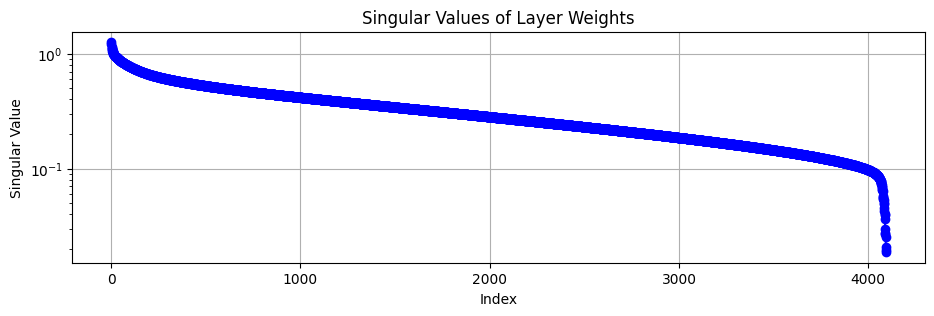

In [23]:
_, S, _ = torch.linalg.svd(X2.float(), full_matrices=False)

# Plot the singular values
plt.figure(figsize=(11, 3))
plt.plot(S, marker='o', linestyle='-', color='b')
plt.title('Singular Values of Layer Weights')
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.yscale('log')
plt.grid(True)
plt.show()

In [26]:
average_bit_level = 3
budget = X2.shape[0] * X2.shape[1] * average_bit_level

L_R_tuple, alpha, beta,  error = lplr_sweep_alpha(X2, budget, B1=2, B2=2, debug=True)

--------------------------------------------------


2024-01-09 15:16:31.567 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:42 - B1=2, B2=2, alpha=0.0, beta=1.16666667
  2%|▏         | 1/49 [00:50<40:38, 50.80s/it]


KeyboardInterrupt: 

In [19]:
compare_against_benchmarks([X2], benchmarkers=benchmarkers)

100%|██████████| 49/49 [00:24<00:00,  2.01it/s]


LoftQ (B=2): [0.6062316596583682]
Mixed Alternating LPLR (B=8): [tensor(0.4945, dtype=torch.float64)]
Uniform Quantization: [0.6351823443685918]
Normal Float Quantization: [0.4072436725925514]


In [8]:
def absmax_quantize_int8(X: torch.Tensor) -> tuple[torch.Tensor, torch.float16]:
    """Quantize each float16/32 data type to int8 and return the maximum value in float16"""
    scale = X.abs().max().item() / 127.0
    int8_tensor = (X / scale).round().to(torch.int8)
    return scale, int8_tensor

In [9]:
def absmax_dequantize_int8(Xq: torch.Tensor, scale: torch.float16) -> torch.Tensor:
    """Dequantize int8 data type to float16/32"""
    return Xq.to(torch.float16) * scale